# Part3 System Level Integration Using PYNQ Flow

Once we have finished optimizing the design of our IP, we need to consider how to put it on the hardware to run. The first thing is how to transfer data between our IP and the hardware. In this part, we use AXI4 interface to load data from PS to PL.

## 1. Two Different Filter2D Implementation to Process Image
### 1.1 Using Filter2D in OpenCV-Python
#### 1.1.1 Load the Original Grayscale Image

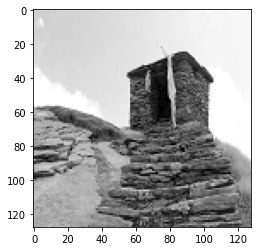

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
gray = cv2.imread("./image/128x128.png", cv2.IMREAD_GRAYSCALE)

plt.imshow(gray, cmap="gray")

#### 1.1.2 Using `cv.filter2D()` with kernel

SW time: 0.005401611328125s


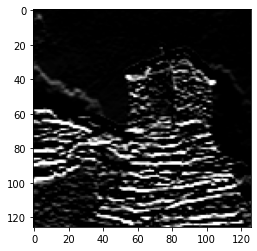

In [2]:
start_time1 = time.time()

kernel = np.array([-1,-2,-1,0,0,0,1,2,1]).reshape(3,3).astype(np.int8)
filtered_img = cv2.filter2D(gray, -1 , kernel)

end_time1 = time.time()

time_python = end_time1 - start_time1

filtered_img_crop = filtered_img[1:-1, 1:-1]
plt.imshow(filtered_img_crop, cmap="gray")

print("SW time: {}s".format(time_python))

### 1.2 Using Hand-Coded Filter2D Hardware Accelerated Kernel

#### 1.2.1 Loading Overlay

We deploy the hardware design to the board, allocate the memory according to the image size, and copy the image to the corresponding location.

The Overlay module encapsulates the interface for the ARM CPU to interact with the PL part of the FPGA.

- We can load the hardware design we just generated onto the PL with the simple `Overlay()` method
- With the `overlay.filter2d_accel_0` statement, we can interact with the IP in the form of an accessed Python object

#### 1.2.2 Allocating memory for IP use

The `pynq.allocate` function is used to allocate memory space that can be used by the IP in PL.
- Before the IP in PL can access DRAM, some memory must be reserved for it to be used by the IP. Allocation size and address.
- We allocate memory for the input, output and kernel buffers separately:
  - `input_buffer` and `output_buffer` is set to `uint8`. 
  - `kernel_buffer` is set to `int8`.
- `pynq.allocate` will allocate physically contiguous memory and return a `pynq.Buffer` indicating that a buffer has been allocated.

In [3]:
from pynq import Overlay, allocate

overlay = Overlay("../prj/Opt_128/overlay/filter2d_kv260.bit")

filter2d = overlay.filter2d_accel_0

# allocate memory
height, width= gray.shape
input_buffer = allocate(shape=(height*width,), dtype= np.uint8)
output_buffer = allocate(shape=((height-2)*(width-2),), dtype= np.uint8)
kernel_buffer = allocate(shape=(3*3,), dtype= np.int8)
    
np.copyto(input_buffer, gray.flatten())
np.copyto(kernel_buffer, kernel.flatten())

#### 1.2.3 Configuring IP

- When writing values on the IP, we can write directly at the corresponding location according to the IP Driver Source Code given by HLS. 
- We can find the address from `/xup_project_based_learning/hls/filter2d/prj/Opt_128/kernel/filter2d/opt/impl/ip/drivers/filter2d_accel_v1_0/src/xfilter2d_accel_hw.h`. 

In [4]:
filter2d.write(0x1c, height)
filter2d.write(0x24, width)
filter2d.write(0x2c, input_buffer.physical_address)
filter2d.write(0x38, output_buffer.physical_address)
filter2d.write(0x10, kernel_buffer.physical_address)

#### 1.2.4 Starting IP

The control signal is located at address 0x00, which we can write and read to control whether the IP start and listen is completed.

In [5]:
import time

start_time = time.time()
filter2d.write(0x00,0x01)
while True:
    reg = filter2d.read(0x00)
    if reg != 1:
        break
end_time = time.time()

time_handcoded = end_time - start_time

print("HW time: {}s".format(time_handcoded))

HW time: 0.0011222362518310547s


The results have been written to the `output_buffer`, which we can view.

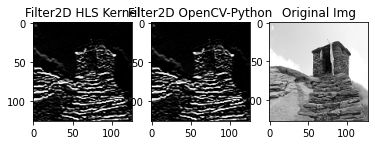

In [9]:
plt.subplot(131)
plt.title("Filter2D HLS Kernel")
plt.imshow(output_buffer.reshape(height-2, width-2),cmap='gray')
plt.subplot(132)
plt.title("Filter2D OpenCV-Python")
plt.imshow(filtered_img_crop,cmap='gray')
plt.subplot(133)
plt.title("Original Img")
plt.imshow(gray, cmap='gray')

## 2. Performance Comparison Between Python-OpenCV and Hand-Coded HLS Kernel

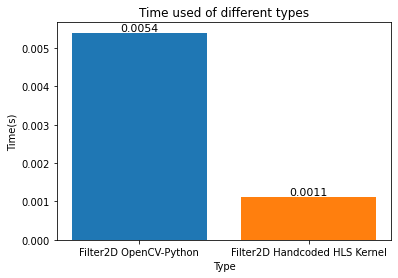

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random

# prepare data
x_data = ['Filter2D OpenCV-Python','Filter2D Handcoded HLS Kernel']
y_data = [time_python, time_handcoded]


for i in range(len(x_data)):
    plt.bar(x_data[i], y_data[i])

for a,b in zip(x_data,y_data):   
    plt.text(a,b,'%.4f'%b,ha='center',va='bottom',fontsize=11);
    
plt.title("Time used of different types")
plt.xlabel("Type")
plt.ylabel("Time(s)")

plt.show()

--------------

<p align="center">Copyright&copy; 2024 Advanced Micro Devices</p>